In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import numpy as np, pandas as pd, seaborn as sns, tensorflow as tf, tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline

Loading Input Data

In [6]:
inputdata=pd.read_excel('/content/input_data.xlsx')
inputdata

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
...,...,...,...,...
8495,emails not coming in from zz mail,\r\n\r\nreceived from: avglmrts.vhqmtiua@gmail...,avglmrts vhqmtiua,GRP_29
8496,telephony_software issue,telephony_software issue,rbozivdq gmlhrtvp,GRP_0
8497,vip2: windows password reset for tifpdchb pedx...,vip2: windows password reset for tifpdchb pedx...,oybwdsgx oxyhwrfz,GRP_0
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62


# Exploratory Data Analysis
## Observations:
1.   Short Description is repeated in Description in many records - Redundant, will be dropped
2.   Caller Name is repeated in Description in many places (not required for our analysis) - Caller column will be dropped
3.   There are tickets in Spanish as well as German apart from English. But English language is dominant.

### The redundant and unwanted features will be removed during the pre-processing of the data

In [8]:
# Total number of records
inputdata.shape
# There are 8500 records and 4 features

(8500, 4)

In [9]:
# Checking for null values
inputdata.isnull().sum()
# There are 8 null values in Short Description and 1 null value in Description
# Will be dropping the null value in 
## Description (since Description is our feature of interest) during data pre-processing

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

Short Description, considered redundant. So only null values of Description column will be dropped. 

## Distribution of tickets based on Assignment Group

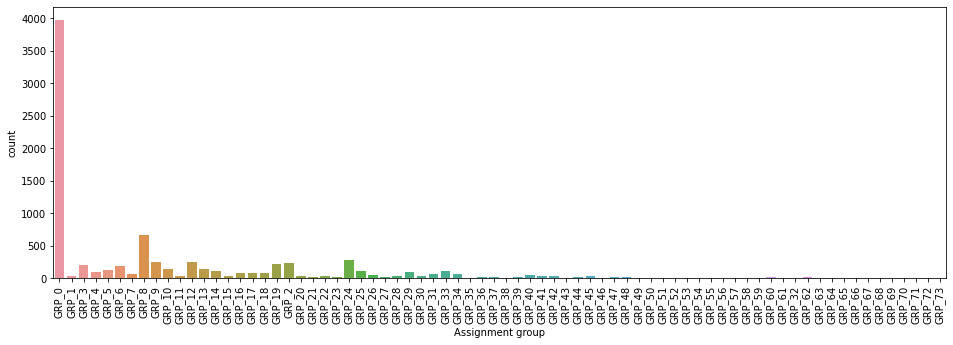

In [10]:
plt.gcf().set_size_inches(16,5)
plt.xticks(rotation=90)
sns.countplot(inputdata['Assignment group'])

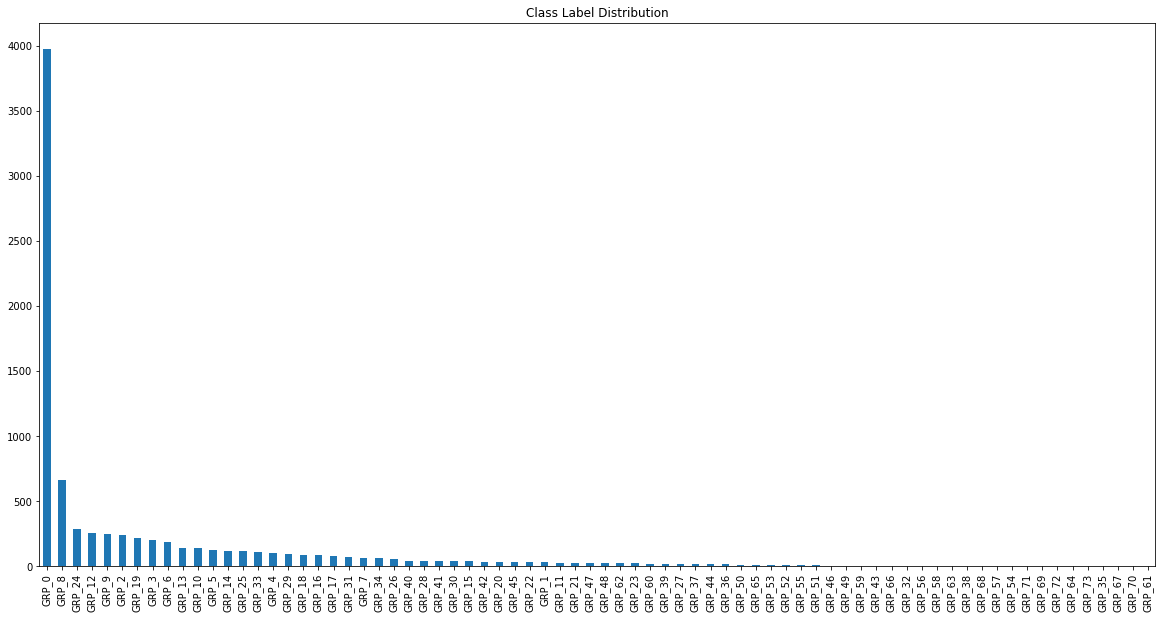

In [11]:
inputdata['Assignment group'].value_counts().plot(kind='bar', figsize=(20,10), title='Class Label Distribution')

In [12]:
# Checking for those assignment groups that have too few tickets (records)
# Defining those assignment groups as low frequency, which have less than 5 tickets assigned to them
freq=pd.DataFrame(inputdata['Assignment group'].value_counts())
freq.reset_index(inplace=True)
freq.rename(columns={0:'Assignment_group',1:'Number of tickets'})
freq[freq['Assignment group']<5]

,index,Assignment group
56,GRP_66,4
57,GRP_32,4
58,GRP_56,3
59,GRP_58,3
60,GRP_63,3
61,GRP_38,3
62,GRP_68,3
63,GRP_57,2
64,GRP_54,2
65,GRP_71,2


In [13]:
freq[freq['Assignment group']<5].count()
#There are 18 low frequency assignment groups. The classification accuracy of these classes might be low.

index               18
Assignment group    18
dtype: int64

## Observations:
1.   The classes are imbalanced. Accuracy score may not be the best performance metric.
2.   Class 0 has the maximum number of tickets assigned, followed by 8, 24, 12, 9, 2 and 19 in that order.



# Data Cleaning and Processing Pipeline

In [14]:
import nltk
from nltk import *
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
#from nltk.corpora import stopwords
print (stopwords.fileids())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


Data Processing

In [15]:
for i in range(len(inputdata['Description'])):
    # Removing new line (\n) and carriage return (\r)
    inputdata.iloc[i]['Description']=re.sub('\n',' ',str(inputdata.iloc[i]['Description']))
    inputdata.iloc[i]['Description']=re.sub('\r',' ',str(inputdata.iloc[i]['Description']))
    #inputdata.iloc[i]['Description']=str(inputdata.iloc[i]['Description']).replace(str(inputdata.iloc[i]['Caller']),'')
    # Removing email tails from Description
    inputdata.iloc[i]['Description']=re.sub('@gmail.com',' ',inputdata.iloc[i]['Description'])
    # Removing numbers and special characters from Description
    inputdata.iloc[i]['Description']=re.sub('[^a-zA-Z]',' ',inputdata.iloc[i]['Description'])#0-9
    # Removing 'received from' from the beginning of Description
    inputdata.iloc[i]['Description']=re.sub('received from',' ',inputdata.iloc[i]['Description'])
    #inputdata.iloc[i]['Description']=inputdata.iloc[i]['Description'].lower().lstrip(' ')  
 
inputdata

,Short description,Description,Caller,Assignment group
0,login issue,verified user details employee manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,hmjdrvpb komuaywn hello team my...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,eylqgodm ybqkwiam hi i cannot lo...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
...,...,...,...,...
8495,emails not coming in from zz mail,avglmrts vhqmtiua good afternoon ...,avglmrts vhqmtiua,GRP_29
8496,telephony_software issue,telephony software issue,rbozivdq gmlhrtvp,GRP_0
8497,vip2: windows password reset for tifpdchb pedx...,vip windows password reset for tifpdchb pedx...,oybwdsgx oxyhwrfz,GRP_0
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62


In [16]:
for i in range(len(inputdata['Description'])):
    #inputdata.iloc[i]['Description']=re.sub('\n',' ',str(inputdata.iloc[i]['Description']))
    #inputdata.iloc[i]['Description']=re.sub('\r',' ',str(inputdata.iloc[i]['Description']))
    # Removing Caller name from Description
    inputdata.iloc[i]['Description']=inputdata.iloc[i]['Description'].replace(inputdata.iloc[i]['Caller'],'')
inputdata   

,Short description,Description,Caller,Assignment group
0,login issue,verified user details employee manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,hello team my meetings skype m...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,hi i cannot log on to vpn best,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
...,...,...,...,...
8495,emails not coming in from zz mail,good afternoon i am not receivin...,avglmrts vhqmtiua,GRP_29
8496,telephony_software issue,telephony software issue,rbozivdq gmlhrtvp,GRP_0
8497,vip2: windows password reset for tifpdchb pedx...,vip windows password reset for tifpdchb pedx...,oybwdsgx oxyhwrfz,GRP_0
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62


In [17]:
# Dropping Caller and Short description columns
intermediate=inputdata.drop(['Caller','Short description'],axis=1)
intermediate

,Description,Assignment group
0,verified user details employee manager na...,GRP_0
1,hello team my meetings skype m...,GRP_0
2,hi i cannot log on to vpn best,GRP_0
3,unable to access hr tool page,GRP_0
4,skype error,GRP_0
...,...,...
8495,good afternoon i am not receivin...,GRP_29
8496,telephony software issue,GRP_0
8497,vip windows password reset for tifpdchb pedx...,GRP_0
8498,i am unable to access the machine utilities to...,GRP_62


In [18]:
# Processing Assignment group
# Remove 'GRP_' from Assignment group name and convert the remaining string to integer
for i in range(len(intermediate['Description'])):
    intermediate.iloc[i]['Assignment group']=intermediate.iloc[i]['Assignment group'].replace('GRP_','')
intermediate['Assignment group']=intermediate['Assignment group'].astype(np.int32)
intermediate

,Description,Assignment group
0,verified user details employee manager na...,0
1,hello team my meetings skype m...,0
2,hi i cannot log on to vpn best,0
3,unable to access hr tool page,0
4,skype error,0
...,...,...
8495,good afternoon i am not receivin...,29
8496,telephony software issue,0
8497,vip windows password reset for tifpdchb pedx...,0
8498,i am unable to access the machine utilities to...,62


In [19]:
# Removing double spaces and spaces in the beginning of the Description
# Converting string to tokens
for i in range(len(intermediate['Description'])):
    #if isinstance(intermediate.iloc[i]['Description'],str):
    intermediate['Description'][i]=intermediate['Description'][i].replace('  ',' ').lstrip(' ').split()
intermediate['Description']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0       [verified, user, details, employee, manager, n...
1       [hello, team, my, meetings, skype, meetings, e...
2                 [hi, i, cannot, log, on, to, vpn, best]
3                    [unable, to, access, hr, tool, page]
4                                          [skype, error]
                              ...                        
8495    [good, afternoon, i, am, not, receiving, the, ...
8496                         [telephony, software, issue]
8497    [vip, windows, password, reset, for, tifpdchb,...
8498    [i, am, unable, to, access, the, machine, util...
8499    [an, mehreren, pc, s, lassen, sich, verschiede...
Name: Description, Length: 8500, dtype: object

In [20]:
nltk.download('words')
from nltk.corpus import words
dictionary=words.words()

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [21]:
# Removing words that do not make sense using nltk's words
for i in range(len(intermediate['Description'])):
    intermediate['Description'][i]=[x for x in intermediate['Description'][i] if x in dictionary]
    print(intermediate['Description'][i])
intermediate

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Streaming output truncated to the last 5000 lines.
['unable', 'to', 'print', 'from', 'the', 'printer', 'color', 'laser', 'connected', 'to', 'the', 'user', 'system', 'the', 'printer', 'to', 'update', 'tried', 'to', 'install', 'the', 'no', 'go', 'contact', 'computer', 'name', 'user', 'to', 'have', 'local', 'it', 'look', 'as', 'there', 'are', 'many', 'similar', 'issue']
['not', 'works', 'at', 'time']
['the', 'ie', 'to', 'on']
['user', 'to', 'change', 'the', 'printer', 'to']
['account', 'locked']
['name', 'language', 'browser', 'explorer', 'customer', 'number', 'telephone', 'summary', 'i', 'am', 'trying', 'to', 'find', 'an', 'expense', 'report', 'to', 'approve', 'i', 'have', 'an', 'that', 'i', 'have', 'one', 'to', 'approve', 'it', 'is', 'not', 'showing', 'up']
['installation']
['cannot', 'connect', 'to', 'engineering', 'application', 'going', 'through', 'company', 'i', 'can', 'access', 'and', 'through', 'the', 'i', 'can', 'access', 'at', 'the', 'office', 'i', 'can', 'not', 'access', 'remot

,Description,Assignment group
0,"[user, employee, manager, name, checked, the, ...",0
1,"[hello, team, my, are, not, in, my, outlook, c...",0
2,"[hi, i, cannot, log, on, to, best]",0
3,"[unable, to, access, tool, page]",0
4,[error],0
...,...,...
8495,"[good, afternoon, i, am, not, the, that, i, se...",29
8496,"[telephony, issue]",0
8497,"[password, reset, for]",0
8498,"[i, am, unable, to, access, the, machine, to, ...",62


In [22]:
temp=[]
for i in range(len(intermediate['Description'])):
  temp.append(' '.join(intermediate['Description'][i]))
temp

['user employee manager name checked the user name in ad and reset the password advised the user to login and check caller confirmed that he was able to login issue resolved',
 'hello team my are not in my outlook calendar can somebody please advise how to correct this kind',
 'hi i cannot log on to best',
 'unable to access tool page',
 'error',
 'unable to log in to engineering tool and',
 'event critical company the value of threshold for oracle d d data d is',
 'ticket no employment status new non employee enter user s name',
 'unable to disable add on outlook',
 'ticket update on',
 'engineering tool not connected and unable to submit',
 'tool site not loading page correctly',
 'unable to login to tool to',
 'user to reset the password',
 'unable to open',
 'ticket update on',
 'company hi i am unable to login to company trying to open a new session the below link but not able to get through help urgently as we are working from home tomorrow due to month end',
 'when screen will n

In [23]:
type(temp)

list

In [24]:
corpus= ' '.join(temp)
corpus

'user employee manager name checked the user name in ad and reset the password advised the user to login and check caller confirmed that he was able to login issue resolved hello team my are not in my outlook calendar can somebody please advise how to correct this kind hi i cannot log on to best unable to access tool page error unable to log in to engineering tool and event critical company the value of threshold for oracle d d data d is ticket no employment status new non employee enter user s name unable to disable add on outlook ticket update on engineering tool not connected and unable to submit tool site not loading page correctly unable to login to tool to user to reset the password unable to open ticket update on company hi i am unable to login to company trying to open a new session the below link but not able to get through help urgently as we are working from home tomorrow due to month end when screen will not come back account locked unable to sign into unable to check hello

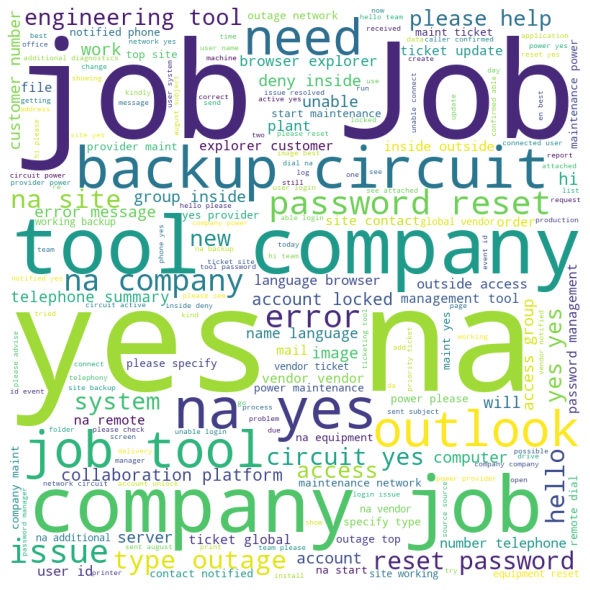

In [25]:
# Using wordcloud to find the most common words in the corpus. Could give an idea of the most common subject
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from random import random
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            #stopwords = stopwords, 
            min_font_size = 10).generate(corpus) #generate(' '.join(inputdata['Description']))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

## Observations:
1. Words YES, NA, JOB and COMPANY are most common. But they do not point to any specific issue
2. Next most common are PASSWORD RESET and OUTLOOK: Issues related to Outlook access and resetting password seem to be the most common complaints

In [26]:
# Removing English stopwords from the tokens
for i in range(len(intermediate['Description'])):
    intermediate['Description'][i]= [word for word in intermediate['Description'][i] if not word in stopwords.words('english')]
   # print(intermediate['Description'][i])
intermediate

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Description,Assignment group
0,"[user, employee, manager, name, checked, user,...",0
1,"[hello, team, outlook, calendar, somebody, ple...",0
2,"[hi, cannot, log, best]",0
3,"[unable, access, tool, page]",0
4,[error],0
...,...,...
8495,"[good, afternoon, sent, mail, please, advise]",29
8496,"[telephony, issue]",0
8497,"[password, reset]",0
8498,"[unable, access, machine, finish, drawers, adj...",62


In [27]:
# Removing Spanish and German stopwords
for i in range(len(intermediate['Description'])):
    intermediate['Description'][i]= [word for word in intermediate['Description'][i] if not word in stopwords.words('spanish')]
    intermediate['Description'][i]= [word for word in intermediate['Description'][i] if not word in stopwords.words('german')]
    
    #print(intermediate['Description'][i])
processed=intermediate
processed

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Description,Assignment group
0,"[user, employee, manager, name, checked, user,...",0
1,"[hello, team, outlook, calendar, somebody, ple...",0
2,"[hi, cannot, log, best]",0
3,"[unable, access, tool, page]",0
4,[error],0
...,...,...
8495,"[good, afternoon, sent, mail, please, advise]",29
8496,"[telephony, issue]",0
8497,"[password, reset]",0
8498,"[unable, access, machine, finish, drawers, adj...",62


### Checking for Descriptions with less than 2 tokens (any Description with less than 2 words many not make sense)

In [28]:
for i in range(len(processed['Description'])):
  if(len(processed['Description'][i])<2):#==0):
    processed=processed.drop(i,axis=0)
processed

,Description,Assignment group
0,"[user, employee, manager, name, checked, user,...",0
1,"[hello, team, outlook, calendar, somebody, ple...",0
2,"[hi, cannot, log, best]",0
3,"[unable, access, tool, page]",0
5,"[unable, log, engineering, tool]",0
...,...,...
8494,"[tablet, needs, due, multiple]",3
8495,"[good, afternoon, sent, mail, please, advise]",29
8496,"[telephony, issue]",0
8497,"[password, reset]",0


In [29]:
processed.reset_index(inplace=True,drop=True)
processed

,Description,Assignment group
0,"[user, employee, manager, name, checked, user,...",0
1,"[hello, team, outlook, calendar, somebody, ple...",0
2,"[hi, cannot, log, best]",0
3,"[unable, access, tool, page]",0
4,"[unable, log, engineering, tool]",0
...,...,...
7772,"[tablet, needs, due, multiple]",3
7773,"[good, afternoon, sent, mail, please, advise]",29
7774,"[telephony, issue]",0
7775,"[password, reset]",0


Now total number of records is 7777

In [30]:
# Creating Porter Stemmer for stemming the words in Description
p_stemmer = PorterStemmer()
temp=[]
for i in range(len(processed['Description'])):
    #processed.iloc[i]['Description']=[p_stemmer.stem(word) for word in processed.iloc[i]['Description']]
    temp.append([p_stemmer.stem(word) for word in processed.iloc[i]['Description']])
temp

[['user',
  'employe',
  'manag',
  'name',
  'check',
  'user',
  'name',
  'ad',
  'reset',
  'password',
  'advis',
  'user',
  'login',
  'check',
  'caller',
  'confirm',
  'abl',
  'login',
  'issu',
  'resolv'],
 ['hello',
  'team',
  'outlook',
  'calendar',
  'somebodi',
  'pleas',
  'advis',
  'correct',
  'kind'],
 ['hi', 'cannot', 'log', 'best'],
 ['unabl', 'access', 'tool', 'page'],
 ['unabl', 'log', 'engin', 'tool'],
 ['event', 'critic', 'compani', 'valu', 'threshold', 'oracl', 'data'],
 ['ticket',
  'employ',
  'statu',
  'new',
  'non',
  'employe',
  'enter',
  'user',
  'name'],
 ['unabl', 'disabl', 'add', 'outlook'],
 ['ticket', 'updat'],
 ['engin', 'tool', 'connect', 'unabl', 'submit'],
 ['tool', 'site', 'load', 'page', 'correctli'],
 ['unabl', 'login', 'tool'],
 ['user', 'reset', 'password'],
 ['unabl', 'open'],
 ['ticket', 'updat'],
 ['compani',
  'hi',
  'unabl',
  'login',
  'compani',
  'tri',
  'open',
  'new',
  'session',
  'link',
  'abl',
  'get',
  'help'

In [31]:
processed['Description']=temp
processed

,Description,Assignment group
0,"[user, employe, manag, name, check, user, name...",0
1,"[hello, team, outlook, calendar, somebodi, ple...",0
2,"[hi, cannot, log, best]",0
3,"[unabl, access, tool, page]",0
4,"[unabl, log, engin, tool]",0
...,...,...
7772,"[tablet, need, due, multipl]",3
7773,"[good, afternoon, sent, mail, pleas, advis]",29
7774,"[telephoni, issu]",0
7775,"[password, reset]",0


In [32]:
# Observed tokens of length 1 and 2, removing them 
temp=[]
for i in range(len(processed['Description'])):
  temp.append([x for x in processed.iloc[i]['Description'] if len(x)>2])  
temp

[['user',
  'employe',
  'manag',
  'name',
  'check',
  'user',
  'name',
  'reset',
  'password',
  'advis',
  'user',
  'login',
  'check',
  'caller',
  'confirm',
  'abl',
  'login',
  'issu',
  'resolv'],
 ['hello',
  'team',
  'outlook',
  'calendar',
  'somebodi',
  'pleas',
  'advis',
  'correct',
  'kind'],
 ['cannot', 'log', 'best'],
 ['unabl', 'access', 'tool', 'page'],
 ['unabl', 'log', 'engin', 'tool'],
 ['event', 'critic', 'compani', 'valu', 'threshold', 'oracl', 'data'],
 ['ticket',
  'employ',
  'statu',
  'new',
  'non',
  'employe',
  'enter',
  'user',
  'name'],
 ['unabl', 'disabl', 'add', 'outlook'],
 ['ticket', 'updat'],
 ['engin', 'tool', 'connect', 'unabl', 'submit'],
 ['tool', 'site', 'load', 'page', 'correctli'],
 ['unabl', 'login', 'tool'],
 ['user', 'reset', 'password'],
 ['unabl', 'open'],
 ['ticket', 'updat'],
 ['compani',
  'unabl',
  'login',
  'compani',
  'tri',
  'open',
  'new',
  'session',
  'link',
  'abl',
  'get',
  'help',
  'urgent',
  'work'

## Final cleaned and processed text

In [33]:
processed['Description']=temp
processed

,Description,Assignment group
0,"[user, employe, manag, name, check, user, name...",0
1,"[hello, team, outlook, calendar, somebodi, ple...",0
2,"[cannot, log, best]",0
3,"[unabl, access, tool, page]",0
4,"[unabl, log, engin, tool]",0
...,...,...
7772,"[tablet, need, due, multipl]",3
7773,"[good, afternoon, sent, mail, pleas, advis]",29
7774,"[telephoni, issu]",0
7775,"[password, reset]",0


# Building the Classification Model
## Importing relevant libraries

In [34]:
from sklearn.naive_bayes import GaussianNBClassifier
#from tensorflow.keras.preprocessing.sequence import pad_sequences

ImportError: ignored

2. Creating Word Embeddings

In [ ]:
lengths=[]
for i in range(len(processed['Description'])):
  lengths.append(len(processed['Description'][i]))
lengths

In [ ]:
max(lengths)

In [ ]:
lengths.index(max(lengths))

In [ ]:
processed.iloc[3642]['Description']

In [ ]:
'''
trimmed=[]
for i in range(len(processed['Description'])):
    print(f'{i}: length before: {lengths[i]}')
    processed['Description'][i]=[x for x in processed['Description'][i] if len(x)>1]
    trimmed.append(len(processed['Description'][i]))
    print(f'{i}: length after: {trimmed[i]}')
'''

In [ ]:
# Joining back cleaned and pre-processed tokens into sentences
temp=[]
for i in range(len(processed['Description'])):
    temp.append(' '.join(processed.iloc[i]['Description']))
processed['Description']=temp
processed

In [ ]:
# Setting embedding parameters (dimensions)
max_features = 2000
maxlen = max(lengths) ## Add your max length here ##
embedding_size = 256

In [ ]:
# Initialise Tokenizer
#tokenizer=Tokenizer(num_words=max_features)
X=[]
for i in range(len(processed['Description'])):
  X.append(text_to_word_sequence(processed.iloc[i]['Description']))
X

In [ ]:
# Get vocabulary
words = set(tuple(row) for row in X)#set(X)
len(words)

In [ ]:
vocab=set()
for x in words:
  vocab.update(x)
vocab

In [ ]:
vocab_size = len(vocab)
vocab_size

## Vectorizing the token sequences
*   Choice of vectorizer: Tf-IDF vectorizer
*   Reason: In the data the key words that point to the issue are fairly frequent but the frequent trivial words need to be ignored

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [ ]:
processed['Description']

In [ ]:
vectorizer.fit(processed['Description'])

In [ ]:
print(vectorizer.vocabulary_)
print(vectorizer.idf_)

In [ ]:
len(vectorizer.vocabulary_)

In [ ]:
len(vectorizer.get_feature_names())

In [ ]:
print(vectorizer.get_feature_names())

In [ ]:
X = vectorizer.transform(processed['Description'])

In [ ]:
X1=X.toarray()
X=pd.DataFrame(X1)
X

In [ ]:
#X = pad_sequences(X, maxlen = maxlen, dtype=str, padding='post')
y = np.asarray(processed['Assignment group'])
#y = pd.Series(y)
y

In [ ]:
print("Shape of Vector matrix: ", X1.shape)

## Creating Train and Test set

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=7)

In [ ]:
x_train

In [ ]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

In [ ]:
sns.countplot(y_test)

# Building Classification model
*   Using Naive Bayes Classification model


In [ ]:
vocab_size

In [ ]:
model = GaussianNB()

In [ ]:
'''
input = Input(shape=(maxlen,))
model = Embedding(vocab_size,embedding_size,weights=[embedding_matrix],input_length=maxlen)(input)
model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.50),merge_mode='concat')(model)
model = Dense(100,activation='relu')(model)
model = Flatten()(model)
model = Dense(100,activation='relu')(model)
output = Dense(73,activation='softmax')(model)
model = Model(input,output)
'''

## Fit the model

In [ ]:
## Add your code here ##
model.fit(x_train,y_train)

# Prediction and Accuracy on Prediction data

In [ ]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,accuracy_score

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred

# Performance metrics

In [ ]:
# Overall accuracy
accuracy_score(y_test,y_pred)

In [ ]:
# Precision
precision_score(y_test,y_pred,average=None)

In [ ]:
# Recall
recall_score(y_test,y_pred,average=None)

In [ ]:
# F1 score
f1_score(y_test,y_pred,average=None)

## Visualise confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.gcf().set_size_inches(25,25)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
cnf_matrix = confusion_matrix(pd.DataFrame(y_test).values.argmax(axis=1), y_pred,#nb2 = GridSearchCV(GaussianNB(), cv=skf, param_grid=params)
                              labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                                      31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,
                                      62,63,64,65,66,67,68,69,70,71,72,73,74])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                                      31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,
                                      62,63,64,65,66,67,68,69,70,71,72,73,74],
                      title='Confusion matrix, without normalization')

In [ ]:

for i in range(len(y_test)):
    print('Expected:', y_test[i], 'Predicted', y_pred[i])
